# EDA

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
import ast
import os

@register_cell_magic
def md_with_code(line, cell):
    parsed = ast.parse(cell)
    if not parsed:
        return
    
    if isinstance(parsed.body[0], ast.Expr) and isinstance(parsed.body[0].value, ast.Str):
        display(Markdown(parsed.body[0].value.s.strip()))
    get_ipython().run_cell(cell)

In [5]:
# Load train.csv
df = pd.read_csv('dataset/train.csv')

# Head
display(df.head())

,class,image_path,name,xmax,xmin,ymax,ymin
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,797.0,701.0,262.0,211.0
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,932.0,786.0,329.0,238.0
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,736.0,657.0,275.0,229.0
3,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,986.0,786.0,136.0,0.0
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,667.0,549.0,228.0,179.0


In [7]:
# Check for missing values
display(df.isnull().sum())

class         0
image_path    0
name          0
xmax          0
xmin          0
ymax          0
ymin          0
dtype: int64

In [9]:
# Check the distribution of classes
class_counts = df['name'].value_counts()
display(class_counts)

GARBAGE              8597
CONSTRUCTION_ROAD    2730
POTHOLES             2625
CLUTTER_SIDEWALK     2253
BAD_BILLBOARD        1555
GRAFFITI             1124
SAND_ON_ROAD          748
UNKEPT_FACADE         127
FADED_SIGNAGE         107
BROKEN_SIGNAGE         83
BAD_STREETLIGHT         1
Name: name, dtype: int64

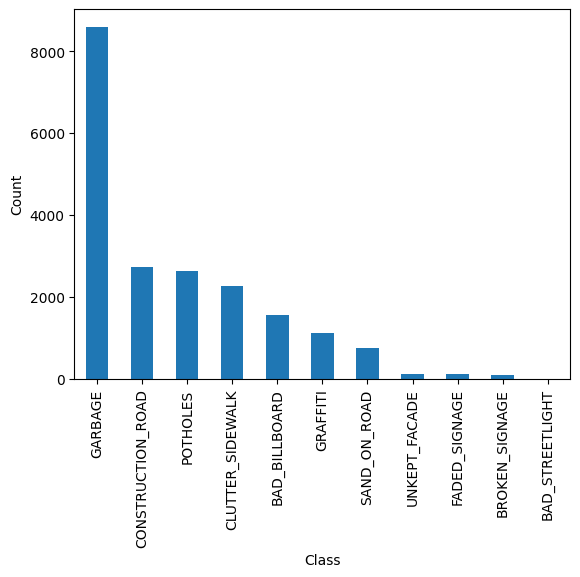

In [10]:

# Class distribution
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [11]:

df.describe()

,class,xmax,xmin,ymax,ymin
count,19950.000000,19950.000000,19950.000000,19950.000000,19950.000000
mean,4.055388,572.813634,362.418647,314.202506,201.514937
std,2.502491,264.445257,264.246281,102.133871,85.536614
min,0.000000,30.000000,-397.000000,20.000000,-150.000000
25%,3.000000,357.000000,147.000000,242.000000,149.000000
50%,3.000000,567.000000,350.000000,296.000000,195.000000
75%,4.000000,789.000000,581.000000,372.000000,251.000000
max,10.000000,1384.000000,935.000000,698.000000,500.000000


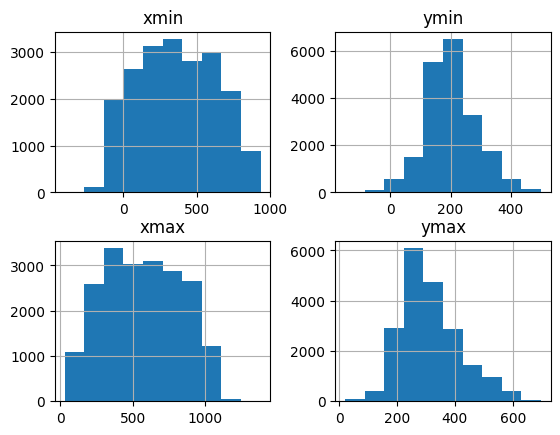

In [12]:
# Plot the distribution of xmin, ymin, xmax, ymax
df.hist(column=['xmin', 'ymin', 'xmax', 'ymax'])
plt.show()

## Coverting Voc format to Yolo format (X,Y,W,H) 

This script converts a dataset from PASCAL VOC format to YOLO format. The dataset is located in a directory called "DATASET" and contains a train.csv file, which has information about the image file name and the bounding box coordinates for the objects in the image.

The script does the following steps:

- Loads the train.csv file into a pandas dataframe
- Fixes bounding box coordinates that are outside of the image resolution
- Creates a new directory called "yolo_data" and copies the image files to this new directory
- Goes through each image and creates a new .txt file for each image, in which it writes the class ID and the bounding box coordinates in YOLO format.
- Prints a message to indicate that the data conversion is completed

In [6]:
!python voc2yolo.py

Data conversion completed!


In [ ]:
# move test images into predict

import pandas as pd
import shutil
path = 'dataset/images'
filenames = pd.read_csv("dataset/test.csv")
filenames = filenames['image_path'].values
for file in filenames:
    shutil.move(os.path.join(path, file),os.path.join('predict', file))

Here we are checking for repeated/similar images in a folder of images. It uses the imagehash library to calculate a hash value for each image and then compares the hash values to find any duplicates.

 `This is useful as having duplicate or similar images in the dataset can negatively affect the performance of the model, as it could lead to overfitting. By identifying and removing duplicate or similar images, the dataset can be improved to better train the object detection model.`

231


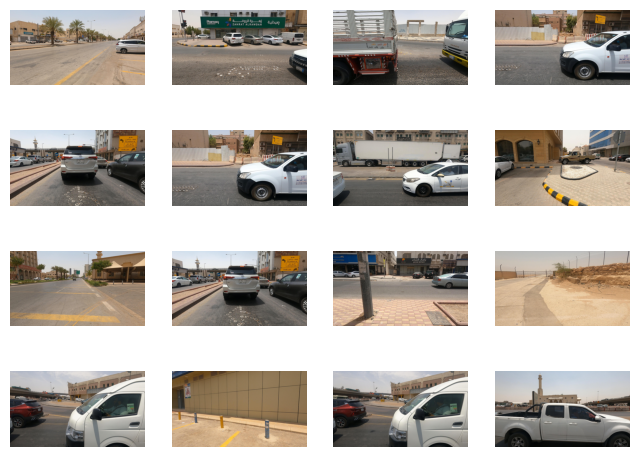

In [26]:
# Check for repeated/similar images

import imagehash
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import argparse


# parser = argparse.ArgumentParser()
# parser.add_argument("-p", "--path", type=str, help="path of yolo formated dataset")
# args = parser.parse_args()

folder = 'yolo_data/train/'

hashes = {}
filenames = []

for filename in os.listdir(folder):
    if filename.endswith('.jpg'):
        image = Image.open(os.path.join(folder, filename))
        hash_value = str(imagehash.phash(image))
        hashes[filename] = hash_value

for key, value in hashes.items():
    for key2, value2 in hashes.items():
        if key != key2:
            if value == value2:
                filenames.append(key)
                filenames.append(key2)

filenames = set(filenames)

print(len(filenames))  
if len(filenames):
    # subplot with a grid of 4x4
    fig, axes = plt.subplots(4, 4, figsize=(8, 6))
    axes_list = [item for sublist in axes for item in sublist]

    for i, filename in enumerate(list(filenames)[:16]):
        img = mpimg.imread(os.path.join(folder, filename))
        axes_list[i].imshow(img)
        axes_list[i].axis('off')
    plt.show()


In [73]:
'''Plot the bounding box coordinates of objects in an image from a YOLO formatted dataset.'''
!python plot_bbox_yolo.py -p yolo_data/train

Incorrect Bounding Box: Few Classes have their bounding boxes bigger than it is supposed to be.
```This could lead to inaccurate object detection results and misclassification of objects.```


In [72]:
""" Fixing bounding box by shring the size towards the center of BBOX on Few Classes
{'GRAFFITI','FADED_SIGNAGE','GARBAGE','BROKEN_SIGNAGE','BAD_BILLBOARD'}"""

classes_to_change = ["0", "1", "3", "5", "7"]
shrink_percentage = 0.2
path = 'yolo_data/train'

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        file_path = os.path.join(path, filename)
        with open(file_path, "r") as file:
            lines = file.readlines()
            for i, line in enumerate(lines):
                # split the line into a list of numbers
                line_list = line.strip().split(" ")
                classes = line_list[0]
                if classes in classes_to_change:

                    x_center = float(line_list[1])
                    y_center = float(line_list[2])
                    width = float(line_list[3])
                    height = float(line_list[4])
                    
                    # x_center = (1 - shrink_percentage) * x_center + 0.5 * shrink_percentage
                    # y_center = (1 - shrink_percentage) * y_center + 0.5 * shrink_percentage
                    width = (1 - shrink_percentage) * width
                    height = (1 - shrink_percentage) * height

                    # updating the line in the file
                    lines[i] = line_list[0] + ' ' + str(x_center) + ' ' + str(y_center) + ' ' + str(width) + ' ' + str(height) + '\n'
            # write the modified lines back to the file
            with open(file_path, "w") as file:
                file.writelines(lines)



Dividing the dataset into two parts, train and validation. Moveing the image and annotation files to their respective folders and generates a YAML data configuration file.

In [1]:

!python train_val_split.py

For training, we have used Yolov5 pre-trained weight and trained the model with the help of Google Colab. We used the following parameters for training: 

- Epochs: 50
- Batch size: 16
- Learning rate: 0.01 (initially)
- Optimizer: SGD
- Image size: 640x640

We used the following data augmentation techniques:

- Horizontal Flip
- Vertical Flip
- Random Rotations
- Random Brightness
- Random Contrast
- Random Hue
- Random Saturation
- Random Color Jitter
- Random Gaussian Blur

We have also used the following techniques for improving the model performance:

- Focal Loss
- Mixup
- Mosaic
- Label Smoothing
- Weight Decay

We have used the following metrics for evaluation:

- Mean Average Precision (mAP)
- Mean Intersection over Union (mIoU)
- Precision
- Recall
- F1-Score

![Confusion Matrix](trained_data/confusion_matrix.png)

In [36]:
# Create submission file
'''Reading the predicted labels from output folder and generates the submission file.
It takes the predicted class_id, center_x, center_y, width and height and convert them bacl into xmin, ymin, xmax and ymax.
'''
!python submission.py -p output/labels